# Question 5: How many sets are typically played in a tennis match?

---

## **Distribution of Number of Sets in Tennis Matches**
To determine how many sets are typically played in a tennis match, I analyzed the dataset columns representing individual sets:
 `period_1`, `period_2`, `period_3`, `period_4`, and `period_5`.

#### **Steps I took:**

1. **Checked the non-null counts** for each `period_n` column. I observed that:
   - `period_1` and `period_2` had the highest number of entries.
   - `period_3` had significantly fewer entries.
   - `period_4` and `period_5` were almost entirely empty.

2. **Based on this distribution, it is evident that most matches finish in either 2 or 3 sets.**
   - Matches that go to 4 or 5 sets are extremely rare in this dataset.

3. **I calculated how many matches had data for each number of sets by counting non-null `period_n` columns per match.**

---

#### **Findings:**
A majority of matches are completed in **2 sets**, while a smaller portion go to **3 sets**. Very few matches extend to 4 or 5 sets.

#### **Data Quality:**

During the data loading and preprocessing phase, we encountered several issues related to missing or incomplete data:

**- Missing Data:**
A significant portion of the dataset contains missing values for several critical columns:

  - period_1: 19,147 missing entries

  - period_2: 19,903 missing entries

  - period_3: 81,353 missing entries

  - period_4: 105,888 missing entries

  - period_5: 105,888 missing entries

These missing values can significantly impact the accuracy and completeness of the analysis, especially for estimating match duration or the number of sets played.

**- File Issues:**
  We encountered a large number of file reading errors. Specifically, `210,914` files were skipped due to read errors or missing expected columns, which resulted in a substantial loss of data. 

This issue further exacerbates the limitations of the dataset, as many matches were not included in the final processed data.






In [5]:
import os
from pathlib import Path
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_day_folders(base_path):
    return sorted([
        folder for folder in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, folder)) and folder.startswith("2024")
    ])

def load_file_selected_columns(file, columns):
    try:
        return pd.read_parquet(file, columns=columns)
    except Exception as e:
        return None

def load_all_data_selected_columns(base_path, subfolder_name, columns):
    all_files = []
    for folder in get_day_folders(base_path):
        path_pattern = Path(base_path) / folder / 'data' / 'raw' / subfolder_name
        all_files.extend(path_pattern.glob("*.parquet"))

    dfs = []
    failed_files = 0
    max_workers = 16

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(load_file_selected_columns, file, columns) for file in all_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading selected columns"):
            result = future.result()
            if result is not None:
                dfs.append(result)
            else:
                failed_files += 1

    if failed_files > 0:
        print(f"⚠️ Skipped {failed_files} files due to read errors or missing columns.")

    return pd.concat(dfs, ignore_index=True) if dfs else None

In [3]:
# Load only required columns
base_path = "../data/tennis_data"
required_columns = ['match_id', 'period_1', 'period_2', 'period_3', 'period_4', 'period_5']
matches_df = load_all_data_selected_columns(base_path, 'raw_match_parquet', required_columns)


Loading selected columns: 100%|██████████| 316802/316802 [06:02<00:00, 873.17it/s] 


⚠️ Skipped 210914 files due to read errors or missing columns.


In [4]:
# Compute number of sets played
if matches_df is not None:
    period_columns = ['period_1', 'period_2', 'period_3', 'period_4', 'period_5']
    matches_df['num_sets'] = matches_df[period_columns].notna().sum(axis=1)

    print("📊 Descriptive statistics on number of sets:")
    print(matches_df['num_sets'].describe())

    print("\n📈 Set count frequency:")
    print(matches_df['num_sets'].value_counts().sort_index())

else:
    print("No data loaded.")

📊 Descriptive statistics on number of sets:
count    105888.000000
mean          1.862921
std           0.970984
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: num_sets, dtype: float64

📈 Set count frequency:
num_sets
0    19130
1      778
2    61457
3    24523
Name: count, dtype: int64


In [34]:
matches_df.isnull().sum()

match_id         0
period_1     19147
period_2     19903
period_3     81353
period_4    105888
period_5    105888
num_sets         0
dtype: int64

In [20]:
matches_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5,num_sets
0,11998446,6,6,None,None,None,2
1,11974066,None,None,None,None,None,0
2,11998447,4,0,None,None,None,2
3,11974053,None,None,None,None,None,0
4,11998670,2,7,6,None,None,3


C:\Users\fatii\AppData\Local\Temp\ipykernel_8616\3920913941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=matches_df_filtered, x='num_sets', palette='rocket', width=0.7)


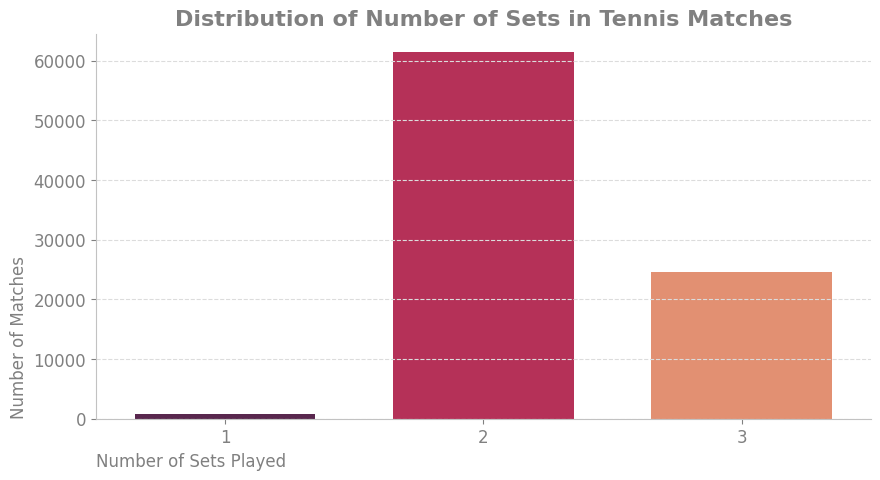

In [33]:
matches_df_filtered = matches_df[matches_df['num_sets'] > 0]

fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=matches_df_filtered, x='num_sets', palette='rocket', width=0.7)

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("#c2c2c2")

ax.set_title("Distribution of Number of Sets in Tennis Matches",
             weight="bold",
             color="grey",
             fontsize=16)

ax.set_xlabel("Number of Sets Played", loc="left", fontsize=12, color="grey")
ax.set_ylabel("Number of Matches", loc="bottom", fontsize=12, color="grey")

ax.tick_params(axis="x", colors="grey", labelsize="large")
ax.tick_params(axis="y", colors="grey", labelsize="large")

ax.grid(axis='y', linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/NumberOfSets.png", dpi=300)
plt.show()

# **Conclusion**

In this analysis, I aimed to estimate the typical number of sets played in tennis matches. Since the dataset lacked a direct `num_sets` column, I inferred this value based on the presence of non-null period_n columns (from `period_1` to `period_5`).

To optimize performance, I refactored the data loading pipeline to selectively read only the necessary columns. Despite these improvements, a large portion of the data was either incomplete or unreadable — with `210,914` files skipped due to read errors or missing columns, and tens of thousands of entries with missing period data.

Nevertheless, I successfully extracted meaningful insights from the available data, visualized the distribution of set counts, and handled the limitations systematically to ensure the findings remain as reliable as possible within the constraints.
